In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import scipy

import os
%matplotlib inline

In [2]:
plt.style.use('default')
plt.rc('font', family='Helvetica')
plt.rcParams['pdf.fonttype'] = 42
sc.set_figure_params(dpi=100, figsize=(8,8), fontsize=20)

## Function

In [4]:
def heatmapPlot(data,
                cmap=None,
                threashold=None,
                fmt = 'd',
                minimum=0,
                figsize=(9.5,7.8),
                mask=None,
                pvalue=None,
                title='',
                save=False):
    """
    """
    plt.style.use('default')
    plt.rc('font', family='Helvetica')
    plt.rcParams['pdf.fonttype'] = 42
    plt.figure(figsize=figsize)
    sns.set_theme(style='white')
    
    plt.figure(figsize=figsize)
    
    tmp = data.copy()
    if threashold is not None:
        tmp[tmp>=threashold] = threashold
    
    if cmap is None:
        cmap = sns.cubehelix_palette(light=1, as_cmap=True, rot=.3, dark=0.3)

    mask = np.triu(np.ones_like(data,dtype=bool),k=1)
    sns.set_theme(font_scale=2.2, font='Helvetica',style='white')
    ax = sns.heatmap(tmp,
                     xticklabels=1,
                     yticklabels=1,
                     cmap=cmap,
                     mask=mask,
                     cbar_kws={"shrink": 1})
    plt.xticks(rotation=60, fontsize=25, ha='right') 
    plt.yticks(rotation=0, fontsize=25)
    plt.title(title, fontsize=30, pad=8)

    thresh = tmp.max().max() / 1.5
    
    import itertools
    fontsize=20
    for i, j in itertools.product(range(data.shape[0]), range(data.shape[1])):
        if j<=i:
            if data.iloc[i, j] >= minimum:
                plt.text(j+0.5, i+0.7, format(data.iloc[i, j], fmt),
                     ha='center', 
                     va='bottom',
                     fontsize=fontsize,
                     color="white" if data.iloc[i, j] > thresh else "black")
                
    if pvalue is not None:
        for i, j in itertools.product(range(tmp.shape[0]), range(tmp.shape[1])):
            if j<=i:
                if tmp.iloc[i, j] >= minimum:
                    if (pvalue.iloc[i, j] < 0.05)&(pvalue.iloc[i, j]>=0.01):
                        plt.text(j+0.5, i+1.1, '*',
                             ha='center', 
                             va='bottom',
                             fontsize=fontsize,
                             color="white" if tmp.iloc[i, j] > thresh else "black")
                    elif (pvalue.iloc[i, j] < 0.01)&(pvalue.iloc[i, j]>=0.001):
                        plt.text(j+0.5, i+1.1, '**',
                             ha='center', 
                             va='bottom',
                             fontsize=fontsize,
                             color="white" if tmp.iloc[i, j] > thresh else "black")
                    elif (pvalue.iloc[i, j] < 0.001):
                        plt.text(j+0.5, i+1.1, '***',
                             ha='center', 
                             va='bottom',
                             fontsize=fontsize,
                             color="white" if tmp.iloc[i, j] > thresh else "black")
    if save:
        plt.savefig(save,dpi=100,format='pdf',bbox_inches='tight')  

def continue_color(start, end, n_colors=10, show=True):
    import colormath
    import numpy as np
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from colormath.color_objects import sRGBColor, HSVColor, LabColor, LCHuvColor, XYZColor, LCHabColor
    from colormath.color_conversions import convert_color

    def hex_to_rgb_color(hex):
        return sRGBColor(*[int(hex[i + 1:i + 3], 16) for i in (0, 2 ,4)], is_upscaled=True)

    def plot_color_palette(colors, subplot, title, plt_count):
        ax = fig.add_subplot(plt_count, 1, subplot)
        for sp in ax.spines: ax.spines[sp].set_visible(False)
        for x, color in enumerate(colors):
            ax.add_patch(mpl.patches.Rectangle((x, 0), 0.95, 1, facecolor=color))
        ax.set_xlim((0, len(colors)))
        ax.set_ylim((0, 1))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect("equal")
        plt.title(title)

    def create_palette(start_rgb, end_rgb, n, colorspace):
        # convert start and end to a point in the given colorspace
        start = convert_color(start_rgb, colorspace).get_value_tuple()
        end = convert_color(end_rgb, colorspace).get_value_tuple()

        # create a set of n points along start to end
        points = list(zip(*[np.linspace(start[i], end[i], n) for i in range(3)]))

        # create a color for each point and convert back to rgb
        rgb_colors = [convert_color(colorspace(*point), sRGBColor) for point in points]

        # finally convert rgb colors back to hex
        return [color.get_rgb_hex() for color in rgb_colors]

    start_color = start
    end_color = end
    number_of_colors = n_colors
    colorspaces = (sRGBColor, HSVColor)#, LabColor, LCHuvColor, LCHabColor, XYZColor)

    start_rgb = hex_to_rgb_color(start_color)
    end_rgb = hex_to_rgb_color(end_color)
    fig = plt.figure(figsize=(number_of_colors, len(colorspaces)), frameon=False)

    # for index, colorspace in enumerate(colorspaces):
    palette = create_palette(start_rgb, end_rgb, number_of_colors, colorspace=sRGBColor)
    if show:
        plot_color_palette(palette, index + 1, colorspace.__name__, len(colorspaces))

        plt.subplots_adjust(hspace=1.5)
        plt.show()
    
    return palette

In [5]:
def InteractionStrength(clumps, cts, method='intensity', weight=False):
    """
    """
    from scipy.special import perm, comb
    out = []
    for clump in clumps:
        df_tmp = pd.DataFrame(index=cts, columns=cts)
        df_tmp = df_tmp.fillna(0)
        tmp = pd.Series(clump).value_counts()
        c = tmp.index
        if method == 'intensity':
            for c1 in c:
                for c2 in c:
                    if tmp.sum()<2:
                        print(clump)
                    if c1 == c2:
                        df_tmp.loc[c1,c2]=comb(tmp[c1],2)/comb(tmp.sum(),2)
                    else:
                        df_tmp.loc[c1,c2]=(tmp[c1]*tmp[c2])/comb(tmp.sum(),2)
            if weight==True:
                out.append(df_tmp*tmp.sum())
            else:
                out.append(df_tmp)
        elif method == 'comb':
            for c1 in c:
                for c2 in c:
                    if c1 == c2:
                        df_tmp.loc[c1,c2]=comb(tmp[c1],2)
                    else:
                        df_tmp.loc[c1,c2]=tmp[c1]*tmp[c2]
            out.append(df_tmp)
        elif method == 'count':
            for i in range(len(clump)):
                for j in range(len(clump)):
                    if i!=j:
                        df_tmp.loc[clump[i],clump[j]]=1
            out.append(df_tmp)
    out = pd.DataFrame(np.sum(out, axis=0), index=cts, columns=cts)
    return out   

## Interaction

In [6]:
df = pd.read_csv('/home/tiankang/tanglei/submit/processed/Fig.5/result.txt', sep='\t', index_col=0)
df = df.loc[df['qc']==1]
df['celltype'] = df['celltype'].astype('category')

epi = sc.read_h5ad('/home/tiankang/tanglei/submit/processed/Fig.5/epi.h5ad')
epi = epi[~epi.obs['leiden'].isin(['16','17','18'])]

In [7]:
df['celltype_refine'] = df['celltype'].astype(str)
c = list(set(df.index).intersection(set(epi.obs_names)))
df.loc[c, 'celltype_refine'] = epi.obs.loc[c,'celltype_refine'].values

df.loc[df['celltype_refine']=='Normal','celltype_refine'] = 'Epi_Normal'
df.loc[df['celltype_refine']=='iCMS3-1','celltype_refine'] = 'Epi_iCMS3-1'
df.loc[df['celltype_refine']=='iCMS3-2','celltype_refine'] = 'Epi_iCMS3-2'
df.loc[df['celltype_refine']=='iCMS2','celltype_refine'] = 'Epi_iCMS2'

df['celltype_leiden'] = df['celltype'].astype(str)
c = list(set(df.index).intersection(set(epi.obs_names)))
df.loc[c, 'celltype_leiden'] = epi.obs.loc[c,'leiden'].values
for leiden in ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15']:
    df.loc[df['celltype_leiden']==leiden,'celltype_leiden'] = 'Epi_' + leiden

In [8]:
clumps_all = df.groupby('CellID')['celltype_leiden'].apply(lambda x:list(x))
clumps = []
for clump in clumps_all:
    if len(clump) > 1:
        clumps.append(clump)
        
cts = ['Epi_0','Epi_7','Epi_9','Epi_4','Epi_11',
       'Epi_2','Epi_1','Epi_3','Epi_5','Epi_6','Epi_8','Epi_10','Epi_12',
       'Epi_13','Epi_14','Epi_15',
       'CD4 T','CD8 T','NK','B','Plasma','Macro','Mast',
       'Mono','DC','TZBTB16','Tgd','Fibro','Granulo','ILC','Endo']

In [9]:
is1 = InteractionStrength(clumps, cts, method='intensity', weight=False)
is2 = InteractionStrength(clumps, cts, method='count', weight=False)

/home/tiankang/software/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/tiankang/software/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [10]:
tmp = df.loc[df['CellID'].isin(df['CellID'].value_counts()[df['CellID'].value_counts()>1].index)]
cellcounts = tmp['celltype_leiden'].value_counts()

obs = is1.copy()
for i in obs.index:
    for j in obs.columns:
        obs.loc[i,j] = 100*obs.loc[i,j]/(cellcounts[i]*cellcounts[j])**0.5

<Figure size 10000x200 with 0 Axes>

<Figure size 3000x2300 with 0 Axes>

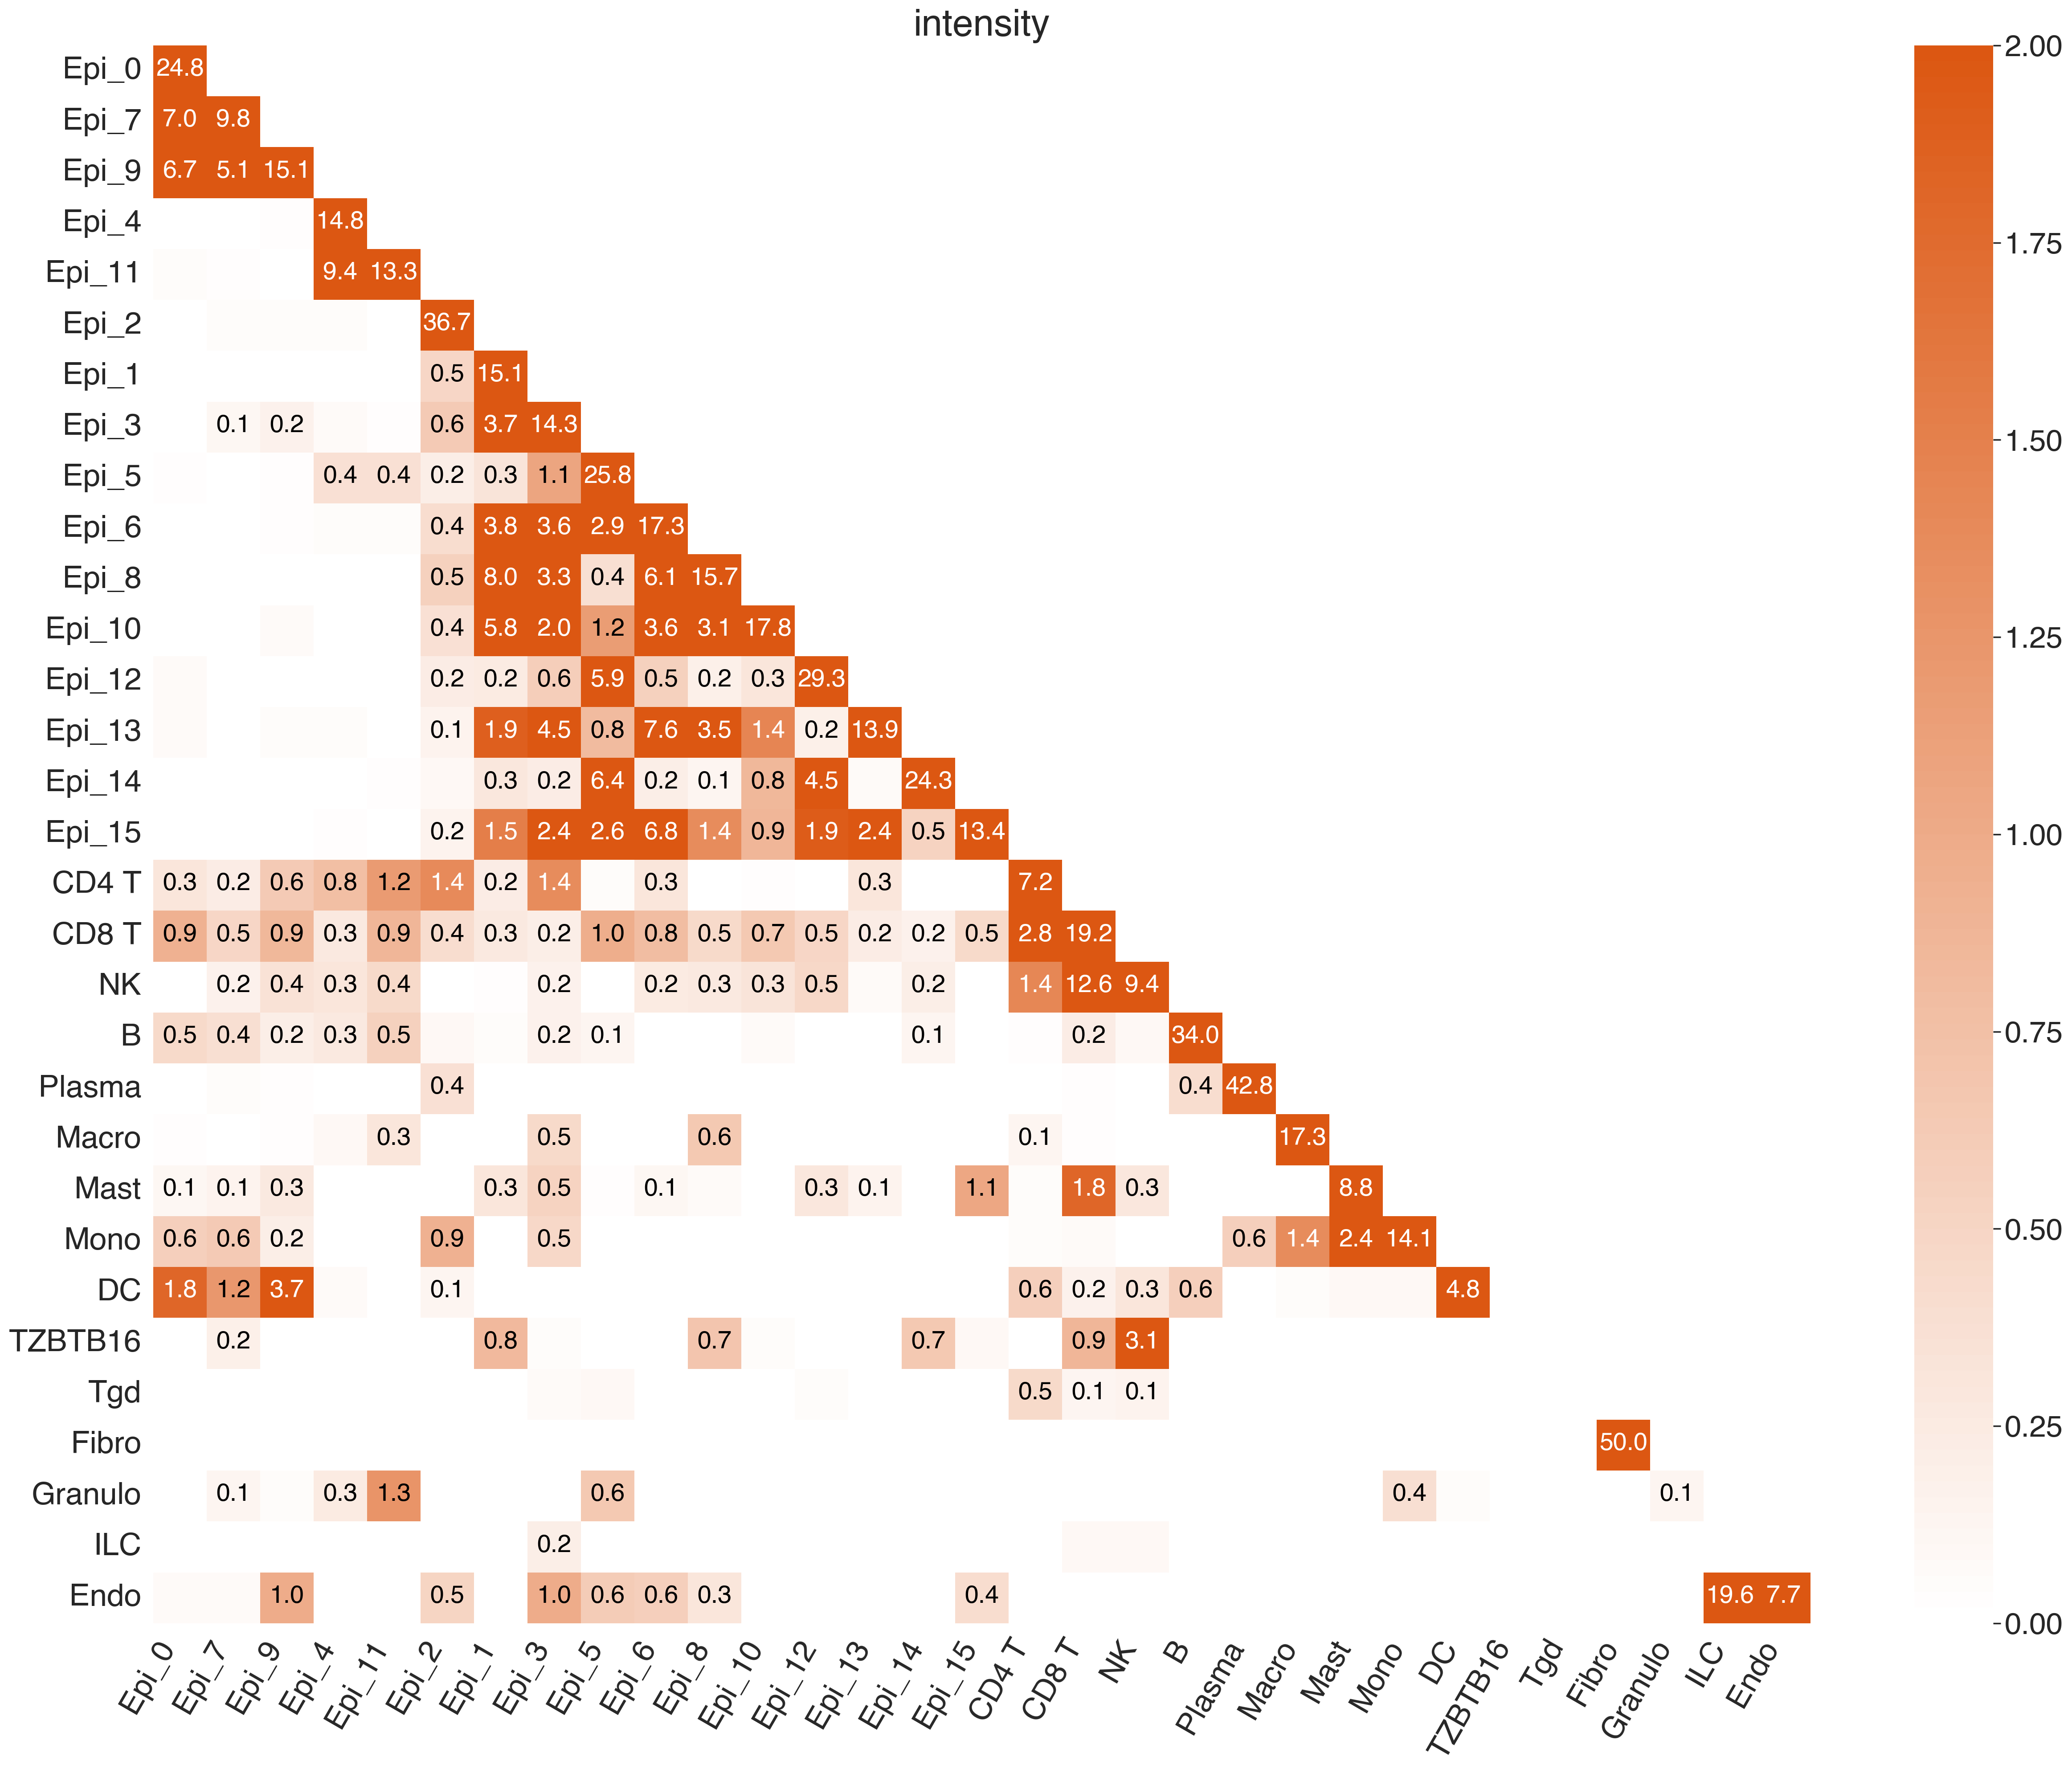

In [11]:
cmap = continue_color("#ffffff", "#dc5712", n_colors=100, show=False)
heatmapPlot(obs, 
            figsize=(30,23), 
            fmt='.1f', 
            minimum=0.1,
            # pvalue=obs, 
            threashold=2, 
            title='intensity',
            cmap=cmap,
            save=False)

<Figure size 3000x2300 with 0 Axes>

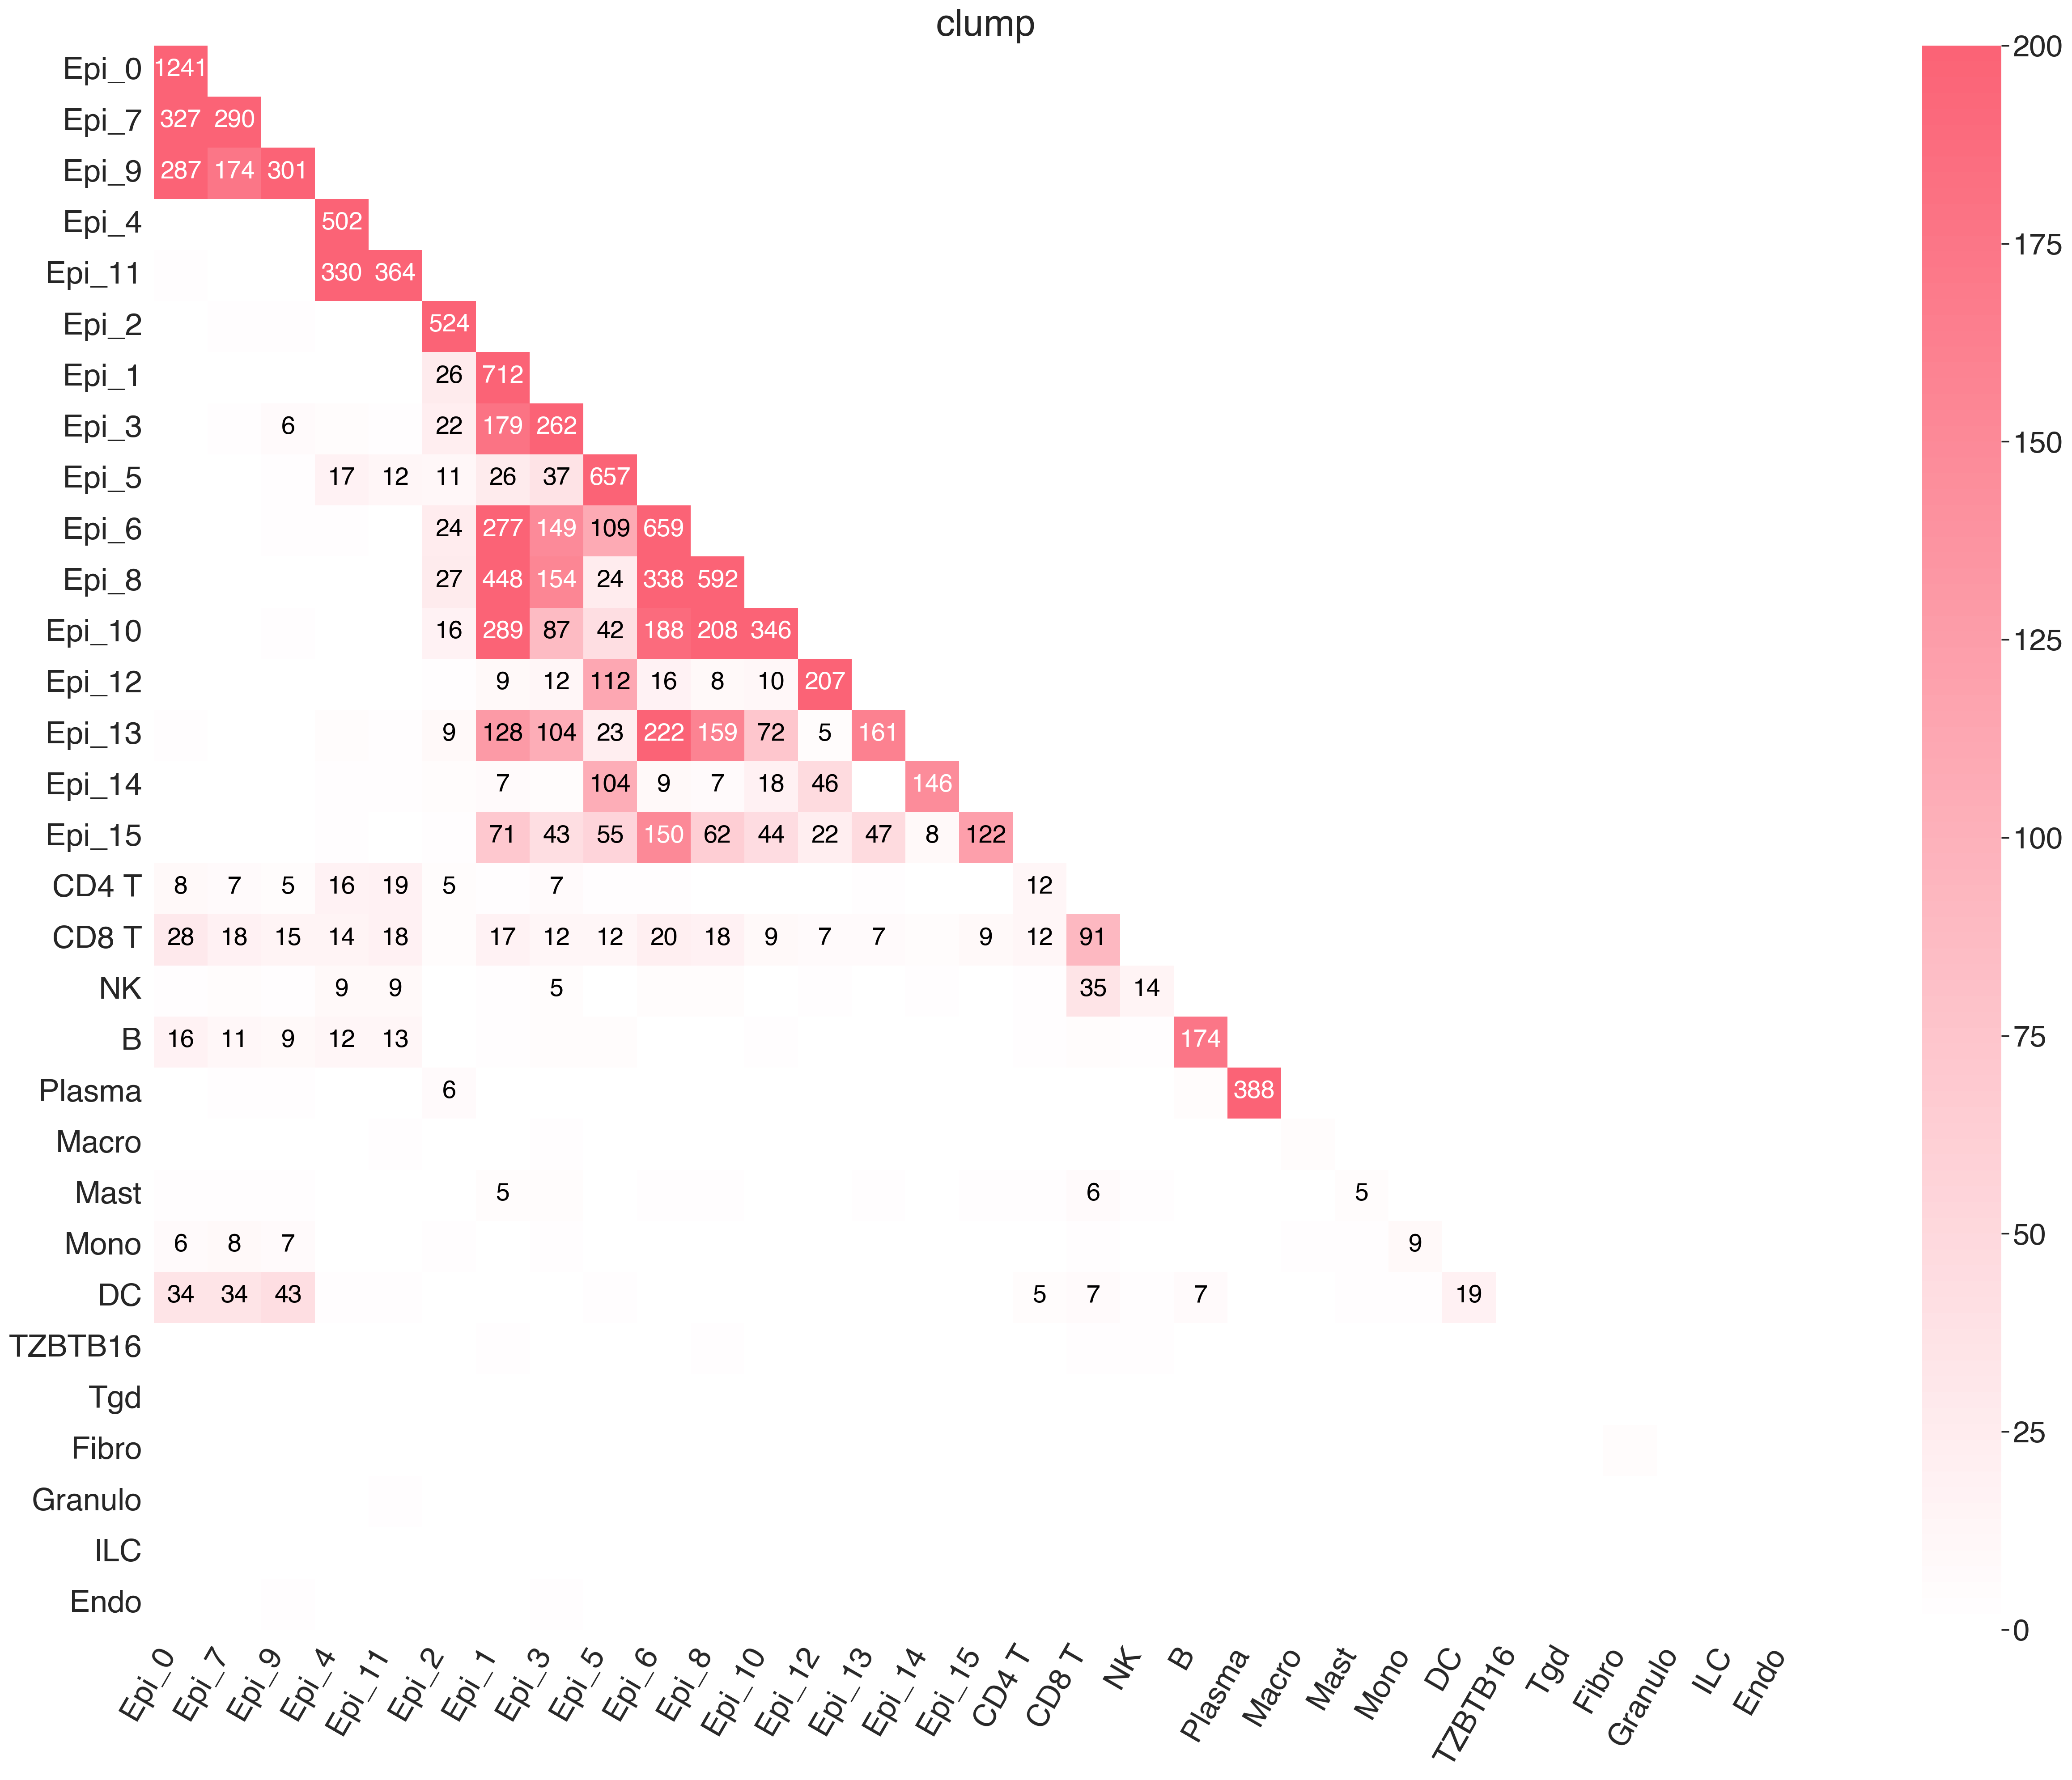

In [17]:
obs = is2.copy().astype(int)
heatmapPlot(obs, 
            figsize=(30,23),
            fmt='d', 
            minimum=5,
            pvalue=obs, 
            threashold=200, 
            title='clump',
            cmap=cmap,
            save=False)